## Initial Setup, EDA, Cleaning



loading dataset through cloning Sam's github repo

In [1]:
import os
import shutil
from PIL import Image
from sklearn.model_selection import train_test_split
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import matplotlib.pyplot as plt
import torch

In [2]:
!rm -rf realwaste

In [3]:
!git clone https://github.com/sam-single/realwaste.git

Cloning into 'realwaste'...
remote: Enumerating objects: 4782, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 4782 (delta 4), reused 8 (delta 1), pack-reused 4764 (from 1)
Receiving objects: 100% (4782/4782), 655.92 MiB | 35.73 MiB/s, done.
Resolving deltas: 100% (4/4), done.
Updating files: 100% (4754/4754), done.


In [4]:
# validate structure
!ls realwaste
!ls realwaste/RealWaste

README.md  RealWaste  realwaste-research.ipynb
 Cardboard	  Glass  'Miscellaneous Trash'	 Plastic	  Vegetation
'Food Organics'   Metal   Paper			'Textile Trash'


organize into recyclable and non-recyclable

In [5]:
# organize into recyclable and non-recyclable
basepath = 'realwaste/RealWaste'
recyclable = os.path.join(basepath, 'recyclable')
non_recyclable = os.path.join(basepath, 'non_recyclable')
os.makedirs(recyclable, exist_ok=True)
os.makedirs(non_recyclable, exist_ok=True)

recyclable_folders = ['Cardboard', 'Glass', 'Metal', 'Paper', 'Plastic']
non_recyclable_folders = ['Miscellaneous Trash', 'Food Organics', 'Textile Trash', 'Vegetation']

# Move recyclable folders
for folder in recyclable_folders:
    src = os.path.join(basepath, folder)
    dst = os.path.join(recyclable, folder)
    shutil.move(src, dst)
    print(f"Moved {folder} to recyclable")

# Move non-recyclable folders
for folder in non_recyclable_folders:
    src = os.path.join(basepath, folder)
    dst = os.path.join(non_recyclable, folder)
    shutil.move(src, dst)
    print(f"Moved {folder} to non-recyclable")

Moved Cardboard to recyclable
Moved Glass to recyclable
Moved Metal to recyclable
Moved Paper to recyclable
Moved Plastic to recyclable
Moved Miscellaneous Trash to non-recyclable
Moved Food Organics to non-recyclable
Moved Textile Trash to non-recyclable
Moved Vegetation to non-recyclable


In [6]:
# Validate new structure
print("Basepath contents:", os.listdir(basepath))
print("Recyclable contents:", os.listdir(recyclable))
print("Non-recyclable contents:", os.listdir(non_recyclable))

Basepath contents: ['recyclable', 'non_recyclable']
Recyclable contents: ['Glass', 'Paper', 'Cardboard', 'Metal', 'Plastic']
Non-recyclable contents: ['Miscellaneous Trash', 'Textile Trash', 'Vegetation', 'Food Organics']


In [7]:
def validate_images(folder_path):
    valid_extensions = ('.jpg', '.jpeg', '.png')
    for subdir, _, files in os.walk(folder_path):
        for file in files:
            file_path = os.path.join(subdir, file)
            # Check if the file has a valid image extension
            if not file.lower().endswith(valid_extensions):
                print(f"Removing non-image file: {file_path}")
                os.remove(file_path)
            else:
                # Try to open and verify the image
                try:
                    with Image.open(file_path) as img:
                        img.verify()  # Verify that it's a valid image
                except Exception as e:
                    print(f"Removing corrupted image: {file_path}")
                    os.remove(file_path)

# Call validate_images on recyclable and non-recyclable folders
validate_images('realwaste/RealWaste/recyclable')
validate_images('realwaste/RealWaste/non_recyclable')


In [8]:
# Another just to check
validate_images('basepath/recyclable')
validate_images('basepath/non-recyclable')

In [9]:
def count_files_in_subdir(root_dir):
    file_counts = {}
    for subdir, _, files in os.walk(root_dir):
        subdir_name = os.path.basename(subdir)
        file_counts[subdir_name] = len(files)
    return file_counts

# Use the correct variable paths
recyclable_counts = count_files_in_subdir(recyclable)
non_recyclable_counts = count_files_in_subdir(non_recyclable)

# Print the counts
print("Total number of files in each subdir of recyclable:")
for subdir, count in recyclable_counts.items():
    print(f"{subdir}: {count}")

print("\nTotal number of files in each subdir of non-recyclable:")
for subdir, count in non_recyclable_counts.items():
    print(f"{subdir}: {count}")


Total number of files in each subdir of recyclable:
recyclable: 0
Glass: 420
Paper: 500
Cardboard: 461
Metal: 790
Plastic: 921

Total number of files in each subdir of non-recyclable:
non_recyclable: 0
Miscellaneous Trash: 495
Textile Trash: 318
Vegetation: 436
Food Organics: 411


In [10]:
import os
import pandas as pd

# Initialize lists for image paths, recyclability, and waste types
image_paths = []
labels = []
waste_types = []

# Define valid image extensions
valid_extensions = ('.jpg', '.jpeg', '.png')

# Populate image paths, labels, and waste types
for label, folder in enumerate(['recyclable', 'non_recyclable']):
    folder_path = os.path.join(basepath, folder)
    for subdir, _, files in os.walk(folder_path):  # Traverse through subdirectories
        for file in files:
            if file.lower().endswith(valid_extensions):  # Only include valid image files
                # Get full image path
                full_path = os.path.join(subdir, file)
                image_paths.append(full_path)
                labels.append(label)

                # Extract waste type from the subdirectory name
                waste_type = os.path.basename(subdir)  # Gets the current subdirectory name
                waste_types.append(waste_type)

# Create the DataFrame with the additional column
data = pd.DataFrame({
    'image': image_paths,
    'labels': labels,
    'waste_type': waste_types
})

print(f"Total images: {len(data)}")
print(data.head())  # Preview the dataset


Total images: 4752
                                               image  labels waste_type
0  realwaste/RealWaste/recyclable/Glass/Glass_355...       0      Glass
1  realwaste/RealWaste/recyclable/Glass/Glass_402...       0      Glass
2  realwaste/RealWaste/recyclable/Glass/Glass_236...       0      Glass
3  realwaste/RealWaste/recyclable/Glass/Glass_233...       0      Glass
4  realwaste/RealWaste/recyclable/Glass/Glass_199...       0      Glass


EDA

In [11]:
print(data.dtypes)

image         object
labels         int64
waste_type    object
dtype: object


In [12]:
# Count the number of images for each waste type
waste_type_counts = data['waste_type'].value_counts()

print(waste_type_counts)


waste_type
Plastic                921
Metal                  790
Paper                  500
Miscellaneous Trash    495
Cardboard              461
Vegetation             436
Glass                  420
Food Organics          411
Textile Trash          318
Name: count, dtype: int64


In [13]:
# Count the number of images for each label
label_type_counts = data['labels'].value_counts()

print(label_type_counts)

labels
0    3092
1    1660
Name: count, dtype: int64


In [14]:
#do all of the images have the same size?
from PIL import Image
import os


image_sizes = {}


for img_path in data['image']:
    try:
        with Image.open(img_path) as img:
            size = img.size  # Get (width, height)
            if size in image_sizes:
                image_sizes[size] += 1
            else:
                image_sizes[size] = 1
    except Exception as e:
        print(f"Error processing {img_path}: {e}")

# Print the unique image sizes and their counts
for size, count in image_sizes.items():
    print(f"Size: {size}, Count: {count}")

# Check if all images have the same size
if len(image_sizes) == 1:
    print("All images have the same size.")
else:
    print("Images have varying sizes.")


Size: (524, 524), Count: 4752
All images have the same size.


In [15]:
#image formats?
data['format'] = data['image'].apply(lambda x: os.path.splitext(x)[1].lower())  # Get file extension

# Count occurrences of each format
format_distribution = data['format'].value_counts()

print("Distribution of image formats:")
print(format_distribution)


Distribution of image formats:
format
.jpg    4752
Name: count, dtype: int64


In [16]:
#duplicate images?
import hashlib

# Function to calculate hash of an image
def calculate_image_hash(image_path):
    try:
        with open(image_path, 'rb') as file:
            return hashlib.md5(file.read()).hexdigest()
    except Exception as e:
        return None  # Return None for unreadable files

# Add a column for image hashes
data['image_hash'] = data['image'].apply(calculate_image_hash)

# Find duplicates based on hashes
duplicate_hashes = data[data.duplicated(subset='image_hash', keep=False)]

if not duplicate_hashes.empty:
    print("Duplicate images found based on content:")
    print(duplicate_hashes)
else:
    print("No duplicate images based on content.")


No duplicate images based on content.


In [17]:
from PIL import Image

def check_image_mode(image_path):
    try:
        with Image.open(image_path) as img:
            return img.mode  # Returns 'RGB', 'RGBA', 'L', etc.
    except Exception as e:
        return None  # Return None for unreadable files

# Apply the function to determine image modes
data['image_mode'] = data['image'].apply(check_image_mode)

# Count occurrences of each mode
mode_distribution = data['image_mode'].value_counts()

print("Distribution of image modes:")
print(mode_distribution)


Distribution of image modes:
image_mode
RGB    4752
Name: count, dtype: int64


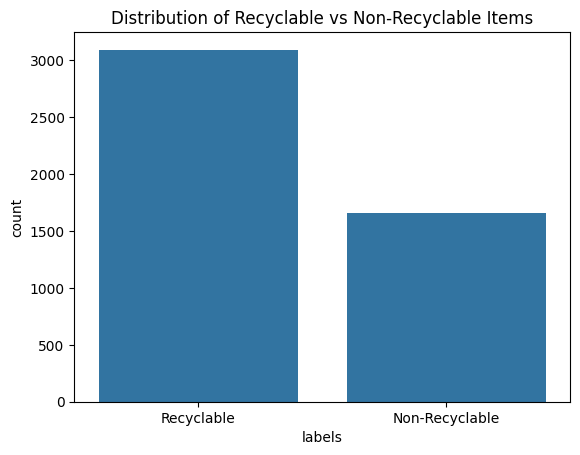

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.countplot(x='labels', data=data)
plt.title('Distribution of Recyclable vs Non-Recyclable Items')
plt.xticks([0, 1], ['Recyclable', 'Non-Recyclable'])
plt.show()


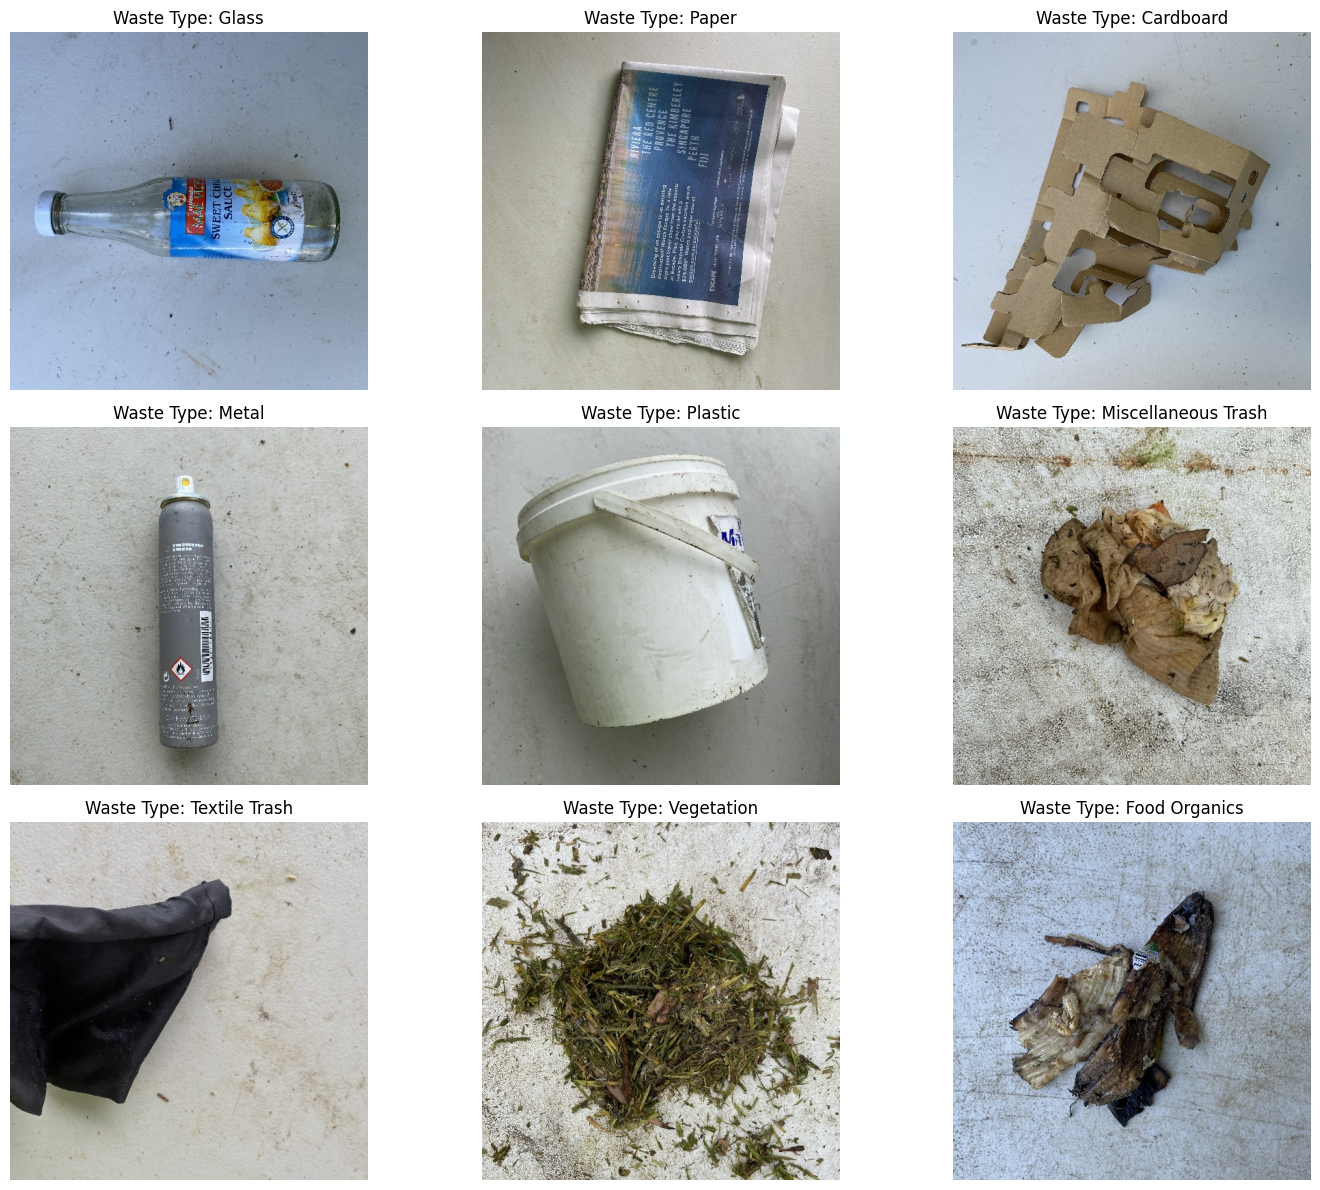

In [19]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

fig, axes = plt.subplots(3, 3, figsize=(15, 12))  # 3 rows, 3 columns
axes = axes.flatten()  # Flatten the axes array for easier iteration

# Get all unique waste types from the 'waste_type' column
waste_types = data['waste_type'].unique()

# Display one example image for each waste type
for i, waste_type in enumerate(waste_types):
    # Get a subset of data for the current waste type
    waste_data = data[data['waste_type'] == waste_type].reset_index(drop=True)

    # Select one random image for the current waste type
    example_image = waste_data['image'].sample(1).values[0]

    # Read and plot the image
    img = mpimg.imread(example_image)
    axes[i].imshow(img)
    axes[i].axis('off')  # Turn off axis
    axes[i].set_title(f'Waste Type: {waste_type}')

plt.tight_layout()
plt.show()


In [20]:
recyclable_images = data[data['labels'] == 0]['image'].sample(5)
non_recyclable_images = data[data['labels'] == 1]['image'].sample(5)

fig, axes = plt.subplots(2, 5, figsize=(15, 7))
for i, img_path in enumerate(recyclable_images):
    ax = axes[0, i]
    ax.imshow(Image.open(img_path))
    ax.set_title('Recyclable')
    ax.axis('off')
for i, img_path in enumerate(non_recyclable_images):
    ax = axes[1, i]
    ax.imshow(Image.open(img_path))
    ax.set_title('Non-Recyclable')
    ax.axis('off')
plt.tight_layout()
plt.show()


In [21]:
# Create a frequency table for the 'labels' column
waste_distribution = data['waste_type'].value_counts()

# Display the frequency table
print(waste_distribution)


waste_type
Plastic                921
Metal                  790
Paper                  500
Miscellaneous Trash    495
Cardboard              461
Vegetation             436
Glass                  420
Food Organics          411
Textile Trash          318
Name: count, dtype: int64


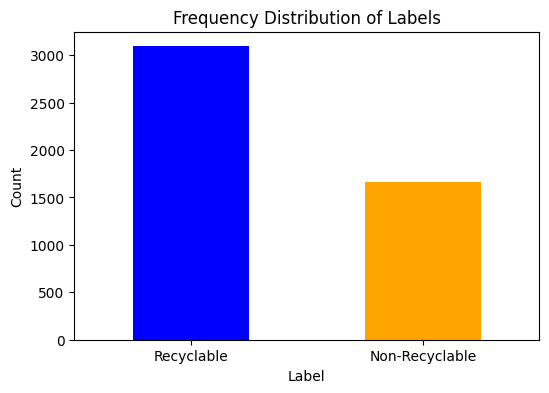

In [22]:
# Plot the bar chart
plt.figure(figsize=(6, 4))
label_distribution = data['labels'].value_counts()
plot_labels = label_distribution
plot_labels.index = label_distribution.index.map({0: 'Recyclable', 1: 'Non-Recyclable'})
plot_labels.plot(kind='bar', color=['blue', 'orange'])

# Adding titles and labels
plt.title('Frequency Distribution of Labels')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=0)  # Optional: Rotate the x-axis labels for better readability

# Show the plot
plt.show()

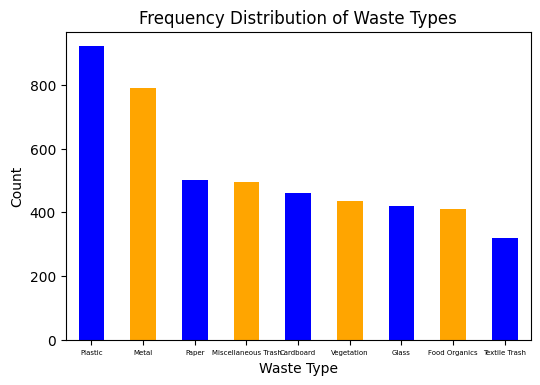

In [23]:
import matplotlib.pyplot as plt

# Create a frequency table for the 'labels' column
waste_distribution = data['waste_type'].value_counts()

# Plot the bar chart
plt.figure(figsize=(6, 4))
waste_distribution.plot(kind='bar', color=['blue', 'orange'])

# Adding titles and labels
plt.title('Frequency Distribution of Waste Types')
plt.xlabel('Waste Type')
plt.ylabel('Count')
plt.xticks(rotation=0)  # Optional: Rotate the x-axis labels for better readability

plt.xticks(fontsize=5)
# Show the plot
plt.show()


In [24]:
# Create a frequency table for the 'image' column
image_distribution = data['image'].value_counts()

# Display the frequency table
print(image_distribution)

image
realwaste/RealWaste/recyclable/Glass/Glass_355.jpg                                    1
realwaste/RealWaste/non_recyclable/Miscellaneous Trash/Miscellaneous Trash_211.jpg    1
realwaste/RealWaste/non_recyclable/Miscellaneous Trash/Miscellaneous Trash_401.jpg    1
realwaste/RealWaste/non_recyclable/Miscellaneous Trash/Miscellaneous Trash_334.jpg    1
realwaste/RealWaste/non_recyclable/Miscellaneous Trash/Miscellaneous Trash_377.jpg    1
                                                                                     ..
realwaste/RealWaste/recyclable/Metal/Metal_598.jpg                                    1
realwaste/RealWaste/recyclable/Metal/Metal_720.jpg                                    1
realwaste/RealWaste/recyclable/Metal/Metal_74.jpg                                     1
realwaste/RealWaste/recyclable/Metal/Metal_221.jpg                                    1
realwaste/RealWaste/non_recyclable/Food Organics/Food Organics_381.jpg                1
Name: count, Length: 4752,

In [25]:
# Count the unique number of images
unique_images_count = data['image'].nunique()

# Print the number of unique images
print(f"Total unique images: {unique_images_count}")


Total unique images: 4752


## Analysis



In [26]:
# Split into train (70%), validation (15%), and test (15%) sets
train_data, temp_data = train_test_split(data, test_size=0.3, stratify=data['labels'], random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=0.5, stratify=temp_data['labels'], random_state=42)

# Output dataset sizes
print(f"Train size: {len(train_data)}")
print(f"Validation size: {len(val_data)}")
print(f"Test size: {len(test_data)}")


Train size: 3326
Validation size: 713
Test size: 713


In [27]:
from torchvision import transforms

# Define transformations for train, validation, and test
transform_train = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize images to 128x128
    transforms.RandomHorizontalFlip(),  # Data augmentation
    transforms.RandomRotation(10),
    transforms.ToTensor(),  # Convert to Tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize (ImageNet stats)
])

transform_test = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize images to 128x128
    transforms.ToTensor(),  # Convert to Tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize (ImageNet stats)
])


In [28]:
from torch.utils.data import Dataset

class WasteDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx, 0]
        label = self.dataframe.iloc[idx, 1]

        # Load image
        image = Image.open(img_path).convert('RGB')  # Ensure 3 channels (RGB)

        if self.transform:
            image = self.transform(image)

        return image, label


In [29]:
from torch.utils.data import DataLoader

# Create dataset instances
train_dataset = WasteDataset(train_data, transform=transform_train)
val_dataset = WasteDataset(val_data, transform=transform_test)
test_dataset = WasteDataset(test_data, transform=transform_test)

# Create DataLoader instances
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

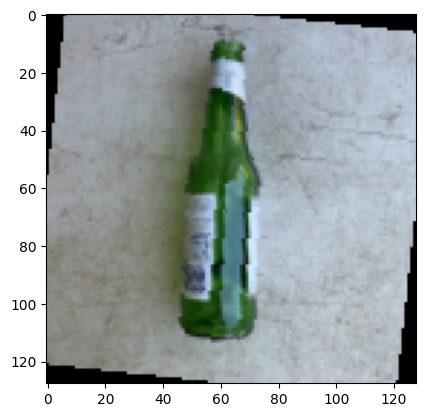

Label: 0


In [30]:
import matplotlib.pyplot as plt
import numpy as np

# Function to unnormalize and display images
def imshow(img):
    img = img * torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1) + torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    img = np.transpose(img.numpy(), (1, 2, 0))
    plt.imshow(img)
    plt.show()

# Get a batch of images and labels
data_iter = iter(train_loader)
images, labels = next(data_iter)

# Display first image in batch
imshow(images[0])
print(f"Label: {labels[0]}")


In [31]:
from torchvision.models import resnet18
import torch.nn as nn

# Load ResNet18 pre-trained on ImageNet
model = resnet18(pretrained=True)

# Replace the last fully connected layer
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)  # Binary classification


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 124MB/s]


In [32]:
import torch.optim as optim

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()  # For multi-class classification
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer

In [33]:
import torch

# Dynamically select the device: GPU if available, otherwise CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move model to the selected device
model = model.to(device)

# Ensure the optimizer is initialized after moving the model to the device
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 20

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}")


Epoch 1/20, Loss: 0.4713
Epoch 2/20, Loss: 0.3160
Epoch 3/20, Loss: 0.2803
Epoch 4/20, Loss: 0.2544
Epoch 5/20, Loss: 0.2262
Epoch 6/20, Loss: 0.2160
Epoch 7/20, Loss: 0.2075
Epoch 8/20, Loss: 0.1796
Epoch 9/20, Loss: 0.1594
Epoch 10/20, Loss: 0.1473
Epoch 11/20, Loss: 0.1501
Epoch 12/20, Loss: 0.1392
Epoch 13/20, Loss: 0.1165
Epoch 14/20, Loss: 0.1342
Epoch 15/20, Loss: 0.1065
Epoch 16/20, Loss: 0.1031
Epoch 17/20, Loss: 0.0985
Epoch 18/20, Loss: 0.1037
Epoch 19/20, Loss: 0.0738
Epoch 20/20, Loss: 0.0842


In [34]:
model.eval()
val_loss = 0.0
correct = 0
total = 0

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        val_loss += loss.item()

        # Get predictions
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

val_accuracy = 100 * correct / total
print(f"Validation Loss: {val_loss/len(val_loader):.4f}, Validation Accuracy: {val_accuracy:.2f}%")


Validation Loss: 0.3508, Validation Accuracy: 91.87%


In [35]:
model.eval()
test_loss = 0.0
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        # Get predictions
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

test_accuracy = 100 * correct / total
print(f"Test Loss: {test_loss/len(test_loader):.4f}, Accuracy: {test_accuracy:.2f}%")


Test Loss: 0.1893, Accuracy: 93.27%


In [36]:
torch.save(model.state_dict(), 'waste_classifier.pth')
print("Model saved as waste_classifier.pth")

Model saved as waste_classifier.pth


In [37]:
# building our own model

In [43]:
import tensorflow as tf
# Define parameters
data_dir = "realwaste/RealWaste"
img_height = 128
img_width = 128
batch_size = 32

# Training Dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

# Validation Dataset
validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

# Print to confirm dataset structure
class_names = train_ds.class_names
print("Class names:", class_names)

Found 4752 files belonging to 2 classes.
Using 3802 files for training.
Found 4752 files belonging to 2 classes.
Using 950 files for validation.
Class names: ['non_recyclable', 'recyclable']


In [44]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, BatchNormalization, Dropout
from tensorflow.keras.regularizers import l2, l1_l2
import keras

In [45]:
myModel  = keras.models.Sequential()

# build the layers of the CNN

#first convolutional layer
myModel.add(Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=(img_height, img_width, 3)))
myModel.add(Activation('relu'))
myModel.add(BatchNormalization())
myModel.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1)))

# additional layers
myModel.add(Conv2D(128, (5, 5), strides=(2, 2), padding='same', input_shape=(img_height, img_width, 3)))
myModel.add(Activation('relu'))
myModel.add(BatchNormalization())
myModel.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1)))

myModel.add(Conv2D(256, (5, 5), strides=(2, 2), padding='same', input_shape=(img_height, img_width, 3)))
myModel.add(Activation('relu'))
myModel.add(BatchNormalization())
myModel.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1)))

myModel.add(Flatten())
myModel.add(Dense(256, activation = 'relu', kernel_regularizer = l2(0.01)))
myModel.add(BatchNormalization())
myModel.add(Dropout(0.6))

myModel.add(Dense(128, activation = 'relu', kernel_regularizer = l2(0.01)))
myModel.add(BatchNormalization())
myModel.add(Dropout(0.6))

#output
myModel.add(Dense(18, activation='softmax'))

myModel.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 64, 64, 64)          │           4,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 64, 64, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 63, 63, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 32, 32, 128)         │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 31, 31, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 16, 16, 256)         │         819,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_5 (Activation)            │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 16, 16, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 15, 15, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 57600)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 256)                 │      14,745,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │              

 Total params: 15,813,650 (60.32 MB)

 Trainable params: 15,811,986 (60.32 MB)

 Non-trainable params: 1,664 (6.50 KB)

In [46]:
# train the model
myEpochs = 20
myOptimizer = keras.optimizers.SGD(learning_rate=0.0001)
myLoss = 'sparse_categorical_crossentropy'
myMetrics = ['accuracy']
myModel.compile(loss= myLoss, optimizer = myOptimizer, metrics = myMetrics)
history = myModel.fit(train_ds, epochs = myEpochs, validation_data = validation_ds)

Epoch 1/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 30s 186ms/step - accuracy: 0.0612 - loss: 11.0891 - val_accuracy: 0.3137 - val_loss: 9.7362
Epoch 2/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 27s 117ms/step - accuracy: 0.1315 - loss: 10.5868 - val_accuracy: 0.3242 - val_loss: 9.5809
Epoch 3/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 21s 122ms/step - accuracy: 0.1950 - loss: 10.1926 - val_accuracy: 0.4400 - val_loss: 9.2344
Epoch 4/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 20s 119ms/step - accuracy: 0.2349 - loss: 10.0372 - val_accuracy: 0.6347 - val_loss: 8.7411
Epoch 5/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 21s 121ms/step - accuracy: 0.2623 - loss: 9.9326 - val_accuracy: 0.6242 - val_loss: 8.7714
Epoch 6/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 20s 118ms/step - accuracy: 0.3023 - loss: 9.7332 - val_accuracy: 0.6200 - val_loss: 8.8538
Epoch 7/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 20s 116ms/step - accuracy: 0.3192 - loss: 9.6878 - val_accuracy: 0.7011 - val_loss: 8.4888
Epoch 8/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 21s 123ms/step - accuracy: 0.3556 - los